<a href="https://colab.research.google.com/github/lolilo52/Neurons/blob/main/%D0%91%D0%BE%D0%B1%D0%B5%D1%804.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Лабораторная работа №4
Меркулов Александр Сергеевич Группа: Бивт-20-4**


Что необходимо сделать (можете вдохновляться ноутбуками для семинара, они должны помочь):

>1.Загрузить датасет (вариант смотреть здесь)


>2.Описать кратенько словами датасет, описать поставку задачи, что от чего >отличаем, привести примеры картинок (картинки можно визуализировать после шага >3, когда у вас будет красивый датасет).

>3.Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо >сделать препроцессинг данных: нормализовать данные, добавить аугментации к >данным и пр.).

>4.Оформить датасет из шага 3 в Dataloader.

>5.Реализовать архитектуру собственной нейросети и натренировать ее на датасете >(можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали >улучшаться).

>6.Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой >вкус (список всех моделей, доступных в torchvision есть тут).

>7.Посчитать метрики качества финальной модели, сделать выводы.


#**Загрузим наш датасет**





In [3]:
!pip install datasets  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.4 MB/s eta 0:00:00


In [7]:
from datasets import load_dataset
dataset = load_dataset('sasha/dog-food')  

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/900 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/sasha___parquet/sasha--dog-food-ec42a61d5519cc88/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

#**Описание датасета**

In [26]:
labels = dataset["test"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    print(i, label)
    label2id[label] = i
    id2label[i] = label
# создаем соответствие между метками классов и их идентификаторами

0 dog
1 food


In [9]:
example = dataset['train'][3]

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 900
    })
})

In [11]:
example['label']

0

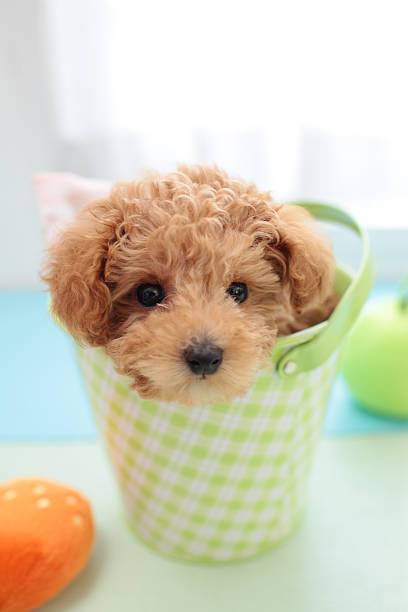

In [12]:
example['image']


В датасете "sasha/dog-food" содержится 2100 тренировочных наборов данных и 900 тестовых наборов данных. Эти наборы данных состоят из изображений, на которых изображены собаки и различные виды еды, а также сопутствующих меток (label).

По завершении обучения нейронная сеть должна быть способна отличать собак от различных видов еды. Это означает, что после обучения нейросети, она должна иметь возможность классифицировать новые изображения и определять, является ли объект на изображении собакой или видом еды.



#**Оформим датасет в виде объекта класса Dataset из PyTorch**#


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import DataLoader

In [30]:
class IdentifysItADogOrAFood(torch.utils.data.Dataset):

  def __init__(self, dataset):
        
      self.dataset = dataset
      
      self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

  def __len__(self):
      return len(self.dataset)
    
  def get_images(self, index):
      return self.transform(self.dataset[index]['image'])
  
  def get_labels(self, index):
      return self.dataset[index]['label']
  
  def __getitem__(self, index):
      train_images = self.get_images(index)
      train_labels = self.get_labels(index)
      return train_images, train_labels
#Определям пользовательский класс IdentifysItADogOrAFood, который наследуется от класса torch.utils.data.Dataset и используется для обработки набора данных, предназначенного для идентификации изображений собак и еды.

# **Оформим датасет в Dataloader**

In [28]:
train_dataset = IdentifysItADogOrAFood(dataset["train"])
test_dataset = IdentifysItADogOrAFood(dataset["test"])

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
class_names = dataset["test"].features["label"].names
dataset_sizes = {
    'train': len(dataset['train']),
    'test': len(dataset['test']),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#создаем переменные class_names, dataset_sizes и device, которые содержат информацию о классах данных, размерах наборов данных и доступном устройстве для выполнения вычислений (GPU или CPU).

# **Выведем наш датасет**


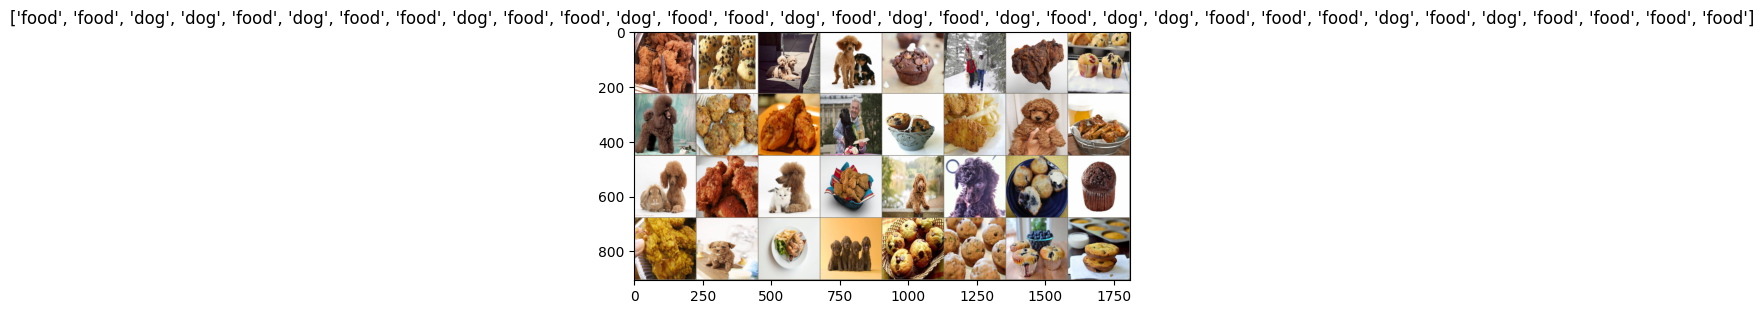

In [29]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
#Отображаем сетку изображений с их соответствующими заголовками, после того как они были преобразованы из формата Tensor в формат NumPy массива, нормализованы, ограничены значениями от 0 до 1

#**Создадим нейросеть**

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch [{}/{}]'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            current_dataloader = train_dataloader
            if phase == 'test':
                current_dataloader = test_dataloader


            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if (epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print('{} Loss: {:.4f} | Accurancy: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model
  

In [20]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.BatchNorm2d(64),

    nn.Flatten(),

    nn.Linear(576, 32),
    nn.Linear(32, 2),
)


model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
model_fitted = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
#В итоге получим* обученную модель с лучшими весами после прохождения обучения на датасете.

Epoch [1/10]
----------
train Loss: 1.1460 | Accurancy: 0.7376
test Loss: 11.4146 | Accurancy: 0.6733

Epoch [2/10]
----------
train Loss: 1.1035 | Accurancy: 0.6152
test Loss: 0.7756 | Accurancy: 0.5222

Epoch [3/10]
----------
train Loss: 0.5528 | Accurancy: 0.7357
test Loss: 0.6900 | Accurancy: 0.5967

Epoch [4/10]
----------
train Loss: 0.5442 | Accurancy: 0.7348
test Loss: 0.5621 | Accurancy: 0.7478

Epoch [5/10]
----------
train Loss: 0.5011 | Accurancy: 0.7700
test Loss: 0.5099 | Accurancy: 0.7656

Epoch [6/10]
----------
train Loss: 0.4649 | Accurancy: 0.7838
test Loss: 0.5076 | Accurancy: 0.7756

Epoch [7/10]
----------
train Loss: 0.4559 | Accurancy: 0.7871
test Loss: 0.4827 | Accurancy: 0.7844

Epoch [8/10]
----------
train Loss: 0.4528 | Accurancy: 0.7957
test Loss: 0.4804 | Accurancy: 0.7867

Epoch [9/10]
----------
train Loss: 0.4446 | Accurancy: 0.7967
test Loss: 0.5118 | Accurancy: 0.7833

Epoch [10/10]
----------
train Loss: 0.4492 | Accurancy: 0.7905
test Loss: 0.5185

#**Результаты работы**

In [21]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    img = transform(img)
    output = model_fitted(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

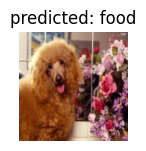

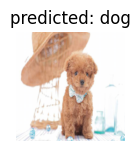

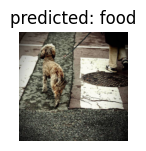

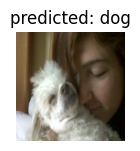

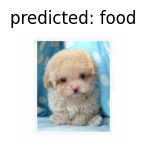

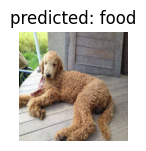

In [23]:
visualize_model(model_fitted, 6)

# **Обучим модель при помощи Transfer Learning**
использовать будем модель VVG-16


In [38]:
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 2)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.1)

In [39]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch [1/10]
----------
train Loss: nan | Accurancy: 0.5295
test Loss: nan | Accurancy: 0.3333

Epoch [2/10]
----------
train Loss: nan | Accurancy: 0.3333
test Loss: nan | Accurancy: 0.3333

Epoch [3/10]
----------
train Loss: nan | Accurancy: 0.3333
test Loss: nan | Accurancy: 0.3333

Epoch [4/10]
----------
train Loss: nan | Accurancy: 0.3333
test Loss: nan | Accurancy: 0.3333

Epoch [5/10]
----------
train Loss: nan | Accurancy: 0.3333
test Loss: nan | Accurancy: 0.3333

Epoch [6/10]
----------
train Loss: nan | Accurancy: 0.3333
test Loss: nan | Accurancy: 0.3333

Epoch [7/10]
----------
train Loss: nan | Accurancy: 0.3333
test Loss: nan | Accurancy: 0.3333

Epoch [8/10]
----------
train Loss: nan | Accurancy: 0.3333
test Loss: nan | Accurancy: 0.3333

Epoch [9/10]
----------
train Loss: nan | Accurancy: 0.3333
test Loss: nan | Accurancy: 0.3333

Epoch [10/10]
----------
train Loss: nan | Accurancy: 0.3333
test Loss: nan | Accurancy: 0.3333

Training complete in 15m 56s
Best val A

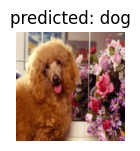

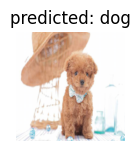

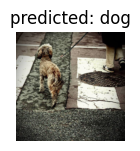

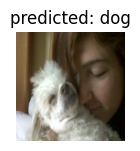

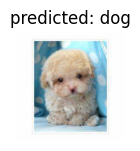

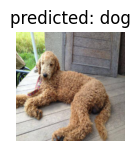

In [40]:
visualize_model(model_ft)